# 作业：单车预测——分类问题版
### 摘要：将‘cnt’数据划分为4个level，并用输出层为4维的神经网络做预测，用交叉熵做损失函数进行反向传播。结果正确率为88%左右。

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
%matplotlib inline

torch.__version__

'1.1.0'

## 数据预处理

In [108]:
data_path = 'Bike-Sharing-Dataset/hour.csv'
rides = pd.read_csv(data_path)

# one-hot
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for each in dummy_fields:
    dummies = pd.get_dummies(rides[each],prefix=each,drop_first=False)
    rides = pd.concat([rides,dummies],axis=1)
    
# drop useless col.
data = rides.drop(['instant', 'dteday', 'season', 'weathersit','weekday', 'atemp', 'mnth', 'workingday', 'hr','casual', 'registered'],axis=1)
data.head(3)

,yr,holiday,temp,hum,windspeed,cnt,season_1,season_2,season_3,season_4,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0,16,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0.22,0.80,0.0,40,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0.22,0.80,0.0,32,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [109]:
# standardize
quant_features = [ 'temp', 'hum', 'windspeed']
scaled_features = {} # [mean, std]
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:,each] = (data[each] - mean)/std
data.head(2)

,yr,holiday,temp,hum,windspeed,cnt,season_1,season_2,season_3,season_4,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,-1.334609,0.947345,-1.553844,16,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,-1.438475,0.895513,-1.553844,40,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [110]:
# A function to divide 'cnt' into 4 levels on average

def cnt_encode(i):
    cnt_range = np.linspace(data['cnt'].min(),data['cnt'].max(),5).astype(int)
    
    if i in range(cnt_range[0],cnt_range[1]) : return 0
    elif i in range(cnt_range[1],cnt_range[2]) : return 1
    elif i in range(cnt_range[2],cnt_range[3]) : return 2
    else : return 3

In [111]:
# test-train-dividing
test_data = data[-31*24:]
train_data = data[:-31*24]
print('train:',len(train_data),'test:',len(test_data))

X = train_data.drop('cnt',axis=1).values
Y = np.array([cnt_encode(i) for i in train_data['cnt'].values])

train: 16635 test: 744


## 学习

In [122]:
#pre-learning
input_size = trX.shape[1]
hidden = 10
batch = 128

neu = torch.nn.Sequential(
    torch.nn.Linear(input_size,hidden),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden,4)
)

cost = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(neu.parameters(), lr = 0.06)

#learning
losses = []
for i in range(1000):
    batch_loss = []
    for start in range(0,len(X),batch):
        end = start + batch if start+batch < len(X) else len(X) #其实不限制边界也没关系。。。
        xx = torch.tensor(X[start:end], dtype = torch.float)
        yy = torch.tensor(Y[start:end], dtype = torch.long)
        predict = neu(xx)
        loss = cost(predict, yy)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        batch_loss.append(loss.data.numpy())
    
    # 每隔100步输出一下损失值（loss）
    if i % 100==0:
        losses.append(np.mean(batch_loss))
        print(i, np.mean(batch_loss))

0 0.8776933
100 0.21755715
200 0.19994397
300 0.19444327
400 0.18985903
500 0.18673372
600 0.18484034
700 0.18366672
800 0.18215822
900 0.18101855


Text(0, 0.5, 'CrossEntropy')

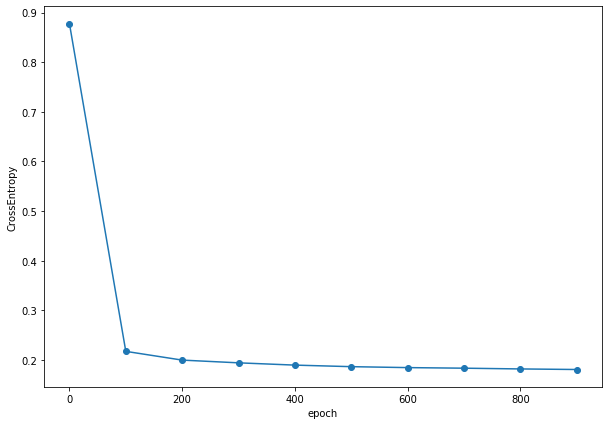

In [123]:
#show the Loss descent
fig = plt.figure(figsize=(10, 7))
plt.plot(np.arange(len(losses))*100,losses, 'o-')
plt.xlabel('epoch')
plt.ylabel('CrossEntropy')

## 测试与评估

In [124]:
#test
tst_features = test_data.drop('cnt',axis=1).values
targets = np.array([cnt_encode(i) for i in test_data['cnt'].values])

x = torch.tensor(tst_features, dtype = torch.float)
y = torch.tensor(targets,dtype = torch.long)

predict = neu(x).max(1)[1].data.tolist()

In [125]:
#Assessment
same = 0
for i,j in zip(predict,y):
    if i == j:
        same += 1
right = same/len(predict)
print(f'预测准确率为：{right*100}%')

预测准确率为：88.03763440860214%


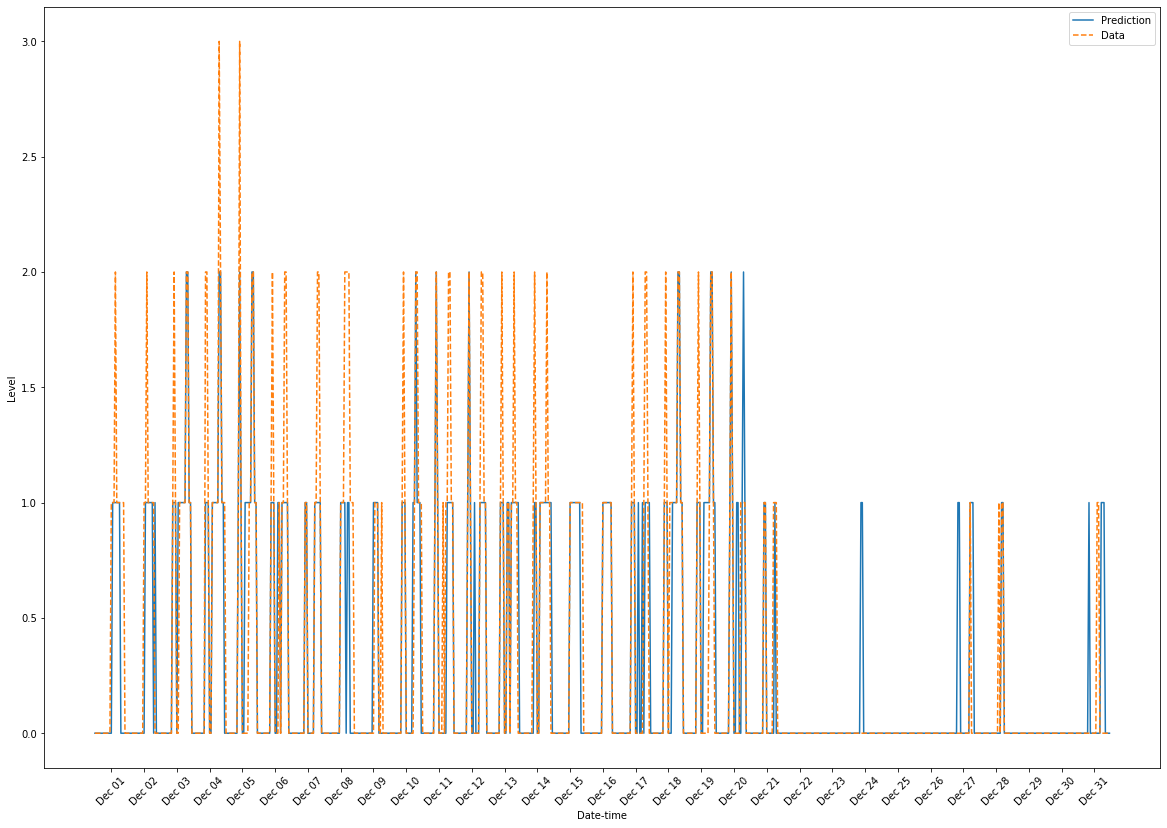

In [126]:
#show of the difference between predictions and results
fig, ax = plt.subplots(figsize = (20, 14))

ax.plot(predict, label='Prediction', linestyle = '-')
ax.plot(y.data.tolist(), label='Data', linestyle = '--')
ax.legend()
ax.set_xlabel('Date-time')
ax.set_ylabel('Level')
# 对横坐标轴进行标注
dates = pd.to_datetime(rides.loc[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)